### وارد کردن داده ها از فایل  دیتاست D.txt

In [12]:
import pandas as pd

file_path = 'D.txt'
df = pd.read_csv(file_path, header=None)

points = df.values.tolist()
points[0]


[6054,
 5991,
 9587,
 4818,
 3991,
 1065,
 479,
 9158,
 388,
 6708,
 4674,
 6778,
 9022,
 4950,
 5196,
 2645,
 591,
 1439,
 8768,
 1386]

### ساخت کلاس نود و کلاس درخت کی دی ، سپس ساخت شی درخت کی دی بوسیله ی داده های دیتاست 

In [13]:
class Node:
    def __init__(self, point, index, left=None, right=None):
        self.point = point
        self.index = index
        self.left = left
        self.right = right

def build_kdtree(points, indices, depth=0):
    if not points:
        return None
    
    k = len(points[0])  
    axis = depth % k    
    
    sorted_points_indices = sorted(zip(points, indices), key=lambda x: x[0][axis])
    sorted_points, sorted_indices = zip(*sorted_points_indices)
    median = len(sorted_points) // 2
    
    return Node(
        point=sorted_points[median],
        index=sorted_indices[median],
        left=build_kdtree(sorted_points[:median], sorted_indices[:median], depth + 1),
        right=build_kdtree(sorted_points[median + 1:], sorted_indices[median + 1:], depth + 1)
    )


kdtree = build_kdtree(points, list(range(len(points))))


### نمایش شهودی درخت کی دی با استفاده از کتابخانه های matplotlib و networkx

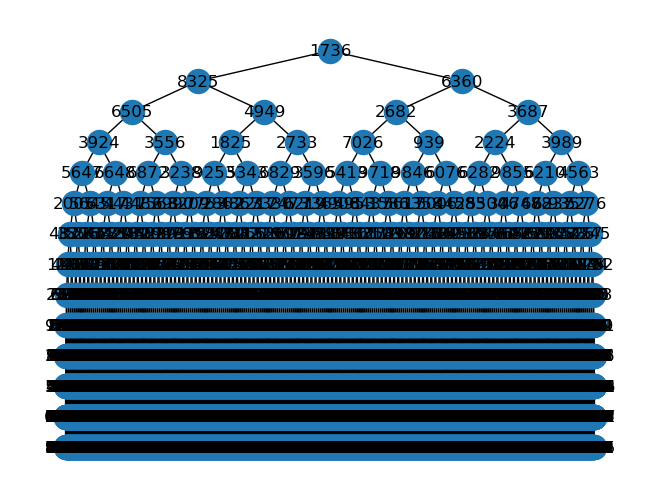

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def add_edges(graph, node, parent=None, pos=None, level=0, width=2.):
    if node is None:
        return
    label = f'{node.index}'  # نمایش شماره نقطه به جای مختصات
    graph.add_node(label, pos=pos)
    if parent:
        graph.add_edge(parent, label)
    
    next_pos = (pos[0] - width / 2 ** (level + 1), pos[1] - 1)
    add_edges(graph, node.left, label, next_pos, level + 1, width)
    
    next_pos = (pos[0] + width / 2 ** (level + 1), pos[1] - 1)
    add_edges(graph, node.right, label, next_pos, level + 1, width)

def plot_tree(tree):
    graph = nx.DiGraph()
    add_edges(graph, tree, pos=(0, 0))
    
    pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos, with_labels=True, arrows=False)
    plt.show()

# نمایش ساختار درخت k-d-tree
plot_tree(kdtree)


### جستجوی درخت ساخته شده براساس داده های دیتاست اولیه برای پیدا کردن نزدیک ترین همسایه به یک نقطه ی دلخوام برای بررسی عملکرد صحیح کد

In [15]:
import numpy as np

def distance_squared(point1, point2):
    return sum((x - y) ** 2 for x, y in zip(point1, point2))

def closest_point(root, point, depth=0, best=None):
    if root is None:
        return best

    k = len(point)  
    axis = depth % k

    next_best = None
    next_branch = None

    if best is None or distance_squared(point, root.point) < distance_squared(point, best.point):
        next_best = root
    else:
        next_best = best

    if point[axis] < root.point[axis]:
        next_branch = root.left
        other_branch = root.right
    else:
        next_branch = root.right
        other_branch = root.left

    next_best = closest_point(next_branch, point, depth + 1, next_best)

    if (point[axis] - root.point[axis]) ** 2 < distance_squared(point, next_best.point):
        next_best = closest_point(other_branch, point, depth + 1, next_best)

    return next_best

# نقطه‌ای که می‌خواهیم نزدیک‌ترین همسایه‌اش را پیدا کنیم
query_point = [9056,4936,1256,2234,874,9685,4053,7645,9161,8849,9742,5102,7711,4614,7976,9190,414,1644,2171,8050]

# پیدا کردن نزدیک‌ترین همسایه
nearest = closest_point(kdtree, query_point)

# نمایش نتیجه
print(f"Closest point index: {nearest.index}")
print(f"Closest point coordinates: {nearest.point}")
print(f"Distance: {np.sqrt(distance_squared(query_point, nearest.point))}")


Closest point index: 6360
Closest point coordinates: [9056, 4936, 1256, 2234, 874, 9685, 4053, 7645, 9161, 8849, 9742, 5102, 7711, 4614, 7976, 9190, 414, 1644, 2171, 8054]
Distance: 4.0


### بررسی امتحانی ، این بار برای پیدا کردن 3 نقطه ی نزدیک

In [16]:
import numpy as np
import heapq

def distance_squared(point1, point2):
    return sum((x - y) ** 2 for x, y in zip(point1, point2))

def closest_points(root, point, k=3, depth=0, heap=None):
    if root is None:
        return

    if heap is None:
        heap = []
    
    dist = distance_squared(point, root.point)
    if len(heap) < k:
        heapq.heappush(heap, (-dist, root))
    else:
        heapq.heappushpop(heap, (-dist, root))
    
    k_dim = len(point)  # تعداد ابعاد
    axis = depth % k_dim

    next_branch = None
    other_branch = None

    if point[axis] < root.point[axis]:
        next_branch = root.left
        other_branch = root.right
    else:
        next_branch = root.right
        other_branch = root.left

    closest_points(next_branch, point, k, depth + 1, heap)

    if len(heap) < k or (point[axis] - root.point[axis]) ** 2 < -heap[0][0]:
        closest_points(other_branch, point, k, depth + 1, heap)

    return heap

# نقطه‌ای که می‌خواهیم نزدیک‌ترین همسایه‌ها را پیدا کنیم
query_point = [9056,4936,1256,2234,874,9685,4053,7645,9161,8849,9742,5102,7711,4614,7976,9190,414,1644,2171,8052]

# پیدا کردن سه نزدیک‌ترین همسایه
nearest_neighbors = closest_points(kdtree, query_point, k=3)

# نمایش نتیجه
nearest_neighbors = sorted(nearest_neighbors, key=lambda x: -x[0])  # مرتب‌سازی همسایه‌ها بر اساس فاصله

for dist, neighbor in nearest_neighbors:
    print(f"Closest point index: {neighbor.index}")
    print(f"Closest point coordinates: {neighbor.point}")
    print(f"Distance: {np.sqrt(-dist)}")


Closest point index: 6360
Closest point coordinates: [9056, 4936, 1256, 2234, 874, 9685, 4053, 7645, 9161, 8849, 9742, 5102, 7711, 4614, 7976, 9190, 414, 1644, 2171, 8054]
Distance: 2.0
Closest point index: 4086
Closest point coordinates: [8505, 3502, 2784, 1200, 1423, 6291, 4947, 7093, 9190, 5768, 6310, 4911, 6832, 4809, 8829, 5689, 2033, 4644, 3237, 6647]
Distance: 8277.910303935409
Closest point index: 3350
Closest point coordinates: [7990, 6032, 2988, 2430, 3332, 6496, 268, 4936, 7724, 7253, 7651, 4116, 4899, 1522, 7558, 8315, 1747, 3954, 4642, 8272]
Distance: 9213.265002158572


#### حالا که از عملکرد کدهایمان مطمعن شدیم 
### از ابتدا فرآیند را اینبار نه فقط برای پیدا کردن نزدیک ترین همسایه ی یک نقطه بلکه برای پیدا کردن نزدیک ترین همسایه ی تمام نقاط دیتاست مورد پرسش تکرار میکنیم.

#### ورودی گرفتن دیتاست اولیه

In [17]:
import pandas as pd

file_path = 'D.txt'
df = pd.read_csv(file_path, header=None, delimiter=',')

points = df.values.tolist()
points[0]

[6054,
 5991,
 9587,
 4818,
 3991,
 1065,
 479,
 9158,
 388,
 6708,
 4674,
 6778,
 9022,
 4950,
 5196,
 2645,
 591,
 1439,
 8768,
 1386]

#### ساخت کلاس نود و کلاس درخت و ساخت درخت بوسیله ی داده های دیتاست اولیه

In [18]:
class Node:
    def __init__(self, point, index, left=None, right=None):
        self.point = point
        self.index = index
        self.left = left
        self.right = right

def build_kdtree(points, indices, depth=0):
    if not points:
        return None
    
    k = len(points[0])  
    axis = depth % k    
    
    sorted_points_indices = sorted(zip(points, indices), key=lambda x: x[0][axis])
    sorted_points, sorted_indices = zip(*sorted_points_indices)
    median = len(sorted_points) // 2
    
    return Node(
        point=sorted_points[median],
        index=sorted_indices[median],
        left=build_kdtree(sorted_points[:median], sorted_indices[:median], depth + 1),
        right=build_kdtree(sorted_points[median + 1:], sorted_indices[median + 1:], depth + 1)
    )

kdtree = build_kdtree(points, list(range(len(points))))


#### ساخت توابع جستجو در درخت

In [19]:
import numpy as np

def distance_squared(point1, point2):
    return sum((x - y) ** 2 for x, y in zip(point1, point2))

def closest_point(root, point, depth=0, best=None, best_dist=float('inf')):
    if root is None:
        return best, best_dist

    dist = distance_squared(point, root.point)
    if dist < best_dist:
        best_dist = dist
        best = root

    k = len(point)  
    axis = depth % k

    next_branch = None
    other_branch = None

    if point[axis] < root.point[axis]:
        next_branch = root.left
        other_branch = root.right
    else:
        next_branch = root.right
        other_branch = root.left

    best, best_dist = closest_point(next_branch, point, depth + 1, best, best_dist)

    if (point[axis] - root.point[axis]) ** 2 < best_dist:
        best, best_dist = closest_point(other_branch, point, depth + 1, best, best_dist)

    return best, best_dist


### وارد کردن دیتاست نقاط پرسش و پیدا کردن نزدیک ترین همسایه به هر کدام با جستجو در درخت از پیش ساخته شده
### و نمایش نقاط و نزدیک ترین همسایه هایشان

In [20]:

def find_nearest_neighbors(new_points):
    results = []
    for point in new_points:
        nearest, dist = closest_point(kdtree, point)
        results.append((point, nearest.point, nearest.index, np.sqrt(dist)))
    return results


new_file_path = 'P.txt'
new_df = pd.read_csv(new_file_path, header=None, delimiter=',')


new_points = new_df.values.tolist()


nearest_neighbors = find_nearest_neighbors(new_points)

# نمایش نتایج
for query, neighbor, index, dist in nearest_neighbors:
    print(f"Query point: {query}")
    print(f"Closest point index: {index}")
    print(f"Closest point coordinates: {neighbor}")
    print(f"Distance: {dist}")
    print("----")


Query point: [6860, 7806, 5405, 1707, 403, 8476, 2541, 283, 1283, 5133, 7800, 8937, 1829, 7768, 7730, 5, 9919, 4053, 3593, 2663]
Closest point index: 8259
Closest point coordinates: [6604, 3486, 5157, 1968, 406, 8632, 8780, 2478, 166, 1984, 8995, 5976, 1585, 6081, 7123, 926, 9643, 6479, 5515, 1596]
Distance: 9944.893564035767
----
Query point: [1732, 7733, 8295, 3948, 7231, 9099, 1694, 9716, 5395, 6470, 6091, 1017, 1888, 720, 5669, 2528, 9532, 4096, 5932, 9528]
Closest point index: 8383
Closest point coordinates: [5064, 5488, 7834, 6070, 8030, 9015, 1288, 9692, 2331, 2449, 2651, 114, 6051, 3717, 5175, 290, 9929, 5553, 7582, 7770]
Distance: 9976.615107339763
----
Query point: [2845, 1325, 2879, 1103, 8281, 7528, 1565, 7825, 8314, 3637, 163, 4370, 6301, 194, 101, 6547, 1321, 5644, 3135, 3714]
Closest point index: 3615
Closest point coordinates: [2912, 843, 3344, 27, 7317, 6698, 1657, 7526, 9706, 1858, 6570, 2738, 5674, 1496, 3568, 5233, 2667, 7081, 4606, 4651]
Distance: 8654.245547706629

### این بار میخواهیم فرآیند پیدا کردن نزدیک ترین همسایه را بدون استفاده از الگوریتم درخت کی دی و با راه حل بدیهی محاسبه ی فاصله همه ی نقاط از هم بررسی کنیم

#### ورودی گرفتن دیتاست اولیه :

In [21]:
import pandas as pd

file_path = 'D.txt'
df = pd.read_csv(file_path, header=None, delimiter=',')

points = df.values.tolist()
points[0]


[6054,
 5991,
 9587,
 4818,
 3991,
 1065,
 479,
 9158,
 388,
 6708,
 4674,
 6778,
 9022,
 4950,
 5196,
 2645,
 591,
 1439,
 8768,
 1386]

### ورودی گرفتن دیتاست نقاط مورد پرسش

In [22]:

new_file_path = 'P.txt'
new_df = pd.read_csv(new_file_path, header=None, delimiter=',')

new_points = new_df.values.tolist()
new_points[0]


[6860,
 7806,
 5405,
 1707,
 403,
 8476,
 2541,
 283,
 1283,
 5133,
 7800,
 8937,
 1829,
 7768,
 7730,
 5,
 9919,
 4053,
 3593,
 2663]

### نوشتن تابع محاسبه ی فاصله نقاط از یکدیگر

In [23]:
import numpy as np

def euclidean_distance(point1, point2):
    return np.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

def find_nearest_neighbors(points, query_points):
    results = []
    for query in query_points:
        min_distance = float('inf')
        nearest_point = None
        nearest_index = -1
        for index, point in enumerate(points):
            distance = euclidean_distance(query, point)
            if distance < min_distance:
                min_distance = distance
                nearest_point = point
                nearest_index = index
        results.append((query, nearest_point, nearest_index, min_distance))
    return results


### پیدا کردن نزدیک ترین همسای برای هر نقطه و نمایش نتایج 

In [24]:
nearest_neighbors = find_nearest_neighbors(points, new_points)

for query, neighbor, index, dist in nearest_neighbors:
    print(f"Query point: {query}")
    print(f"Closest point index: {index}")
    print(f"Closest point coordinates: {neighbor}")
    print(f"Distance: {dist}")
    print("----")


Query point: [6860, 7806, 5405, 1707, 403, 8476, 2541, 283, 1283, 5133, 7800, 8937, 1829, 7768, 7730, 5, 9919, 4053, 3593, 2663]
Closest point index: 8259
Closest point coordinates: [6604, 3486, 5157, 1968, 406, 8632, 8780, 2478, 166, 1984, 8995, 5976, 1585, 6081, 7123, 926, 9643, 6479, 5515, 1596]
Distance: 9944.893564035767
----
Query point: [1732, 7733, 8295, 3948, 7231, 9099, 1694, 9716, 5395, 6470, 6091, 1017, 1888, 720, 5669, 2528, 9532, 4096, 5932, 9528]
Closest point index: 8383
Closest point coordinates: [5064, 5488, 7834, 6070, 8030, 9015, 1288, 9692, 2331, 2449, 2651, 114, 6051, 3717, 5175, 290, 9929, 5553, 7582, 7770]
Distance: 9976.615107339763
----
Query point: [2845, 1325, 2879, 1103, 8281, 7528, 1565, 7825, 8314, 3637, 163, 4370, 6301, 194, 101, 6547, 1321, 5644, 3135, 3714]
Closest point index: 3615
Closest point coordinates: [2912, 843, 3344, 27, 7317, 6698, 1657, 7526, 9706, 1858, 6570, 2738, 5674, 1496, 3568, 5233, 2667, 7081, 4606, 4651]
Distance: 8654.245547706629